# Importing TensorFlow

In [1]:
!nvidia-smi

Tue Jun 18 17:24:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P4             14W /  100W |      14MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [3]:
import tensorflow as tf
print(tf.__version__)

2024-06-18 17:24:59.745091: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 17:24:59.770182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 17:24:59.770204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 17:24:59.770859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 17:24:59.775993: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

# Preparing data

In [5]:
(train_data, test_data), ds_features = tfds.load(
    "food101",
    split = ["train", "validation"],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

2024-06-18 17:25:01.812519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6070 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
ds_features.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
class_names = ds_features.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
sample_img = test_data.take(1)
for image, label in sample_img:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class: {label}
    Class name: {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class: 83
    Class name: red_velvet_cake
    


In [9]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

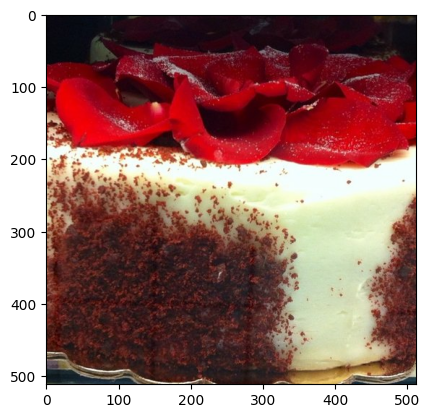

In [10]:
plt.imshow(image)

In [11]:
def preprocess_img(image, label, img_shape=300, rescale=True):
    image = tf.image.resize(image, [img_shape, img_shape])
    if rescale==False:
        return tf.cast(image, tf.float32), label
    else:
        return tf.cast(image, tf.float32)/255., label

In [12]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [14]:
data_aug_layers = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [15]:
train_data_aug = train_data.map(lambda x, y: (data_aug_layers(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint/cp.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

# Creating and training InceptionV3 model

In [18]:
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(101, kernel_regularizer=tf.keras.regularizers.L2(0.005), activation='softmax')(x)

model = tf.keras.models.Model(inception.input, predictions)


In [19]:
model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    metrics = ['accuracy'])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [21]:
history = model.fit(
    x = train_data,
    validation_data = test_data,
    epochs = 20,
    callbacks = [model_checkpoint]
)

Epoch 1/20


2024-06-18 17:25:11.522049: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 17:25:11.533686: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-18 17:25:11.580150: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 17:25:26.886828: I external/local_xla/xla/service/service.cc:168] XLA service 0x5fd7052b1890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 17:25:26.886859: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1718720726.924150   11989 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - 383s 151ms/step - loss: 5.0548 - accuracy: 0.0470 - val_loss: 4.7409 - val_accuracy: 0.1420
Epoch 2/20
2368/2368 [==============================] - 355s 150ms/step - loss: 4.3939 - accuracy: 0.1859 - val_loss: 3.6899 - val_accuracy: 0.3618
Epoch 3/20
2368/2368 [==============================] - 358s 151ms/step - loss: 3.5783 - accuracy: 0.3341 - val_loss: 2.8299 - val_accuracy: 0.5101
Epoch 4/20
2368/2368 [==============================] - 358s 151ms/step - loss: 2.9863 - accuracy: 0.4347 - val_loss: 2.3122 - val_accuracy: 0.5916
Epoch 5/20
2368/2368 [==============================] - 359s 151ms/step - loss: 2.5914 - accuracy: 0.5093 - val_loss: 2.0026 - val_accuracy: 0.6454
Epoch 6/20
2368/2368 [==============================] - 359s 151ms/step - loss: 2.3088 - accuracy: 0.5655 - val_loss: 1.8013 - val_accuracy: 0.6794
Epoch 7/20
2368/2368 [==============================] - 358s 151ms/step - loss: 2.0975 - accuracy: 0.6084 - val_loss: 1.661

<Axes: >

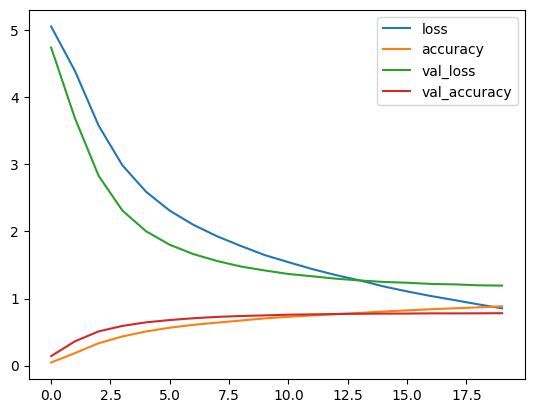

In [22]:
pd.DataFrame(history.history).plot()

# Evaluating

In [ ]:
x_test = np.concatenate([x for x, y in test_data], axis=0)

2024-06-18 19:26:08.997235: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1164] failed to alloc 17179869184 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-06-18 19:26:08.997344: W external/local_xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 17179869184
2024-06-18 19:26:08.997434: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1164] failed to alloc 15461881856 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-06-18 19:26:08.997444: W external/local_xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 15461881856


In [ ]:
y_test = np.concatenate([y for x, y in test_data], axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix
pred_probs = model.predict(x_test)
preds = (np.round(pred_probs)).astype(int)
cm = confusion_matrix(y_test, preds)

In [ ]:
f,ax = plt.subplots(figsize = (6,6))
sns.heatmap(cm, annot=True, linewidths=0.1, cmap = "rocket", linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Summary

Augmented data was not used because of long training time.

Model reached 78.12% val_accuracy on 20th epoch.

Model did not showed overfitting.